# functions


In [29]:
import numpy as np
def my_sort(arr, col_index, order):
    """
    Sorts a NumPy array by a specific column in ascending or descending order.

    Parameters:
        arr (numpy.ndarray): The array to sort.
        col_index (int): The index of the column to sort by.
        order (str): 'ascending' or 'descending'

    Returns:
        numpy.ndarray: The sorted array.
    """

    if order == 'ascending':
        # Get the indices that would sort the specified column in ascending order
        sorted_indices = np.argsort(arr[:, col_index])
        
        # Sort the entire array by these indices
        sorted_arr = arr[sorted_indices]

    if order == 'descending':
        # Get the indices that would sort the specified column in descending order
        sorted_indices = np.argsort(-arr[:, col_index])
        
        # Sort the entire array by these indices
        sorted_arr = arr[sorted_indices]
    
    return sorted_arr

# input

In [30]:
# # input txt
# def readTxt():
#     data = []
#     with open("../data/R15.txt","r") as f:
#         for line in f.readlines():
#             line = line.strip("\n")
#             line = line.split()
#             data.append([float(i) for i in line])   
#     return data
# df = readTxt()
# df = np.array(df, dtype = np.float32)

In [31]:
# input csv
import pandas as pd
df = pd.read_csv('../data/spiral_312p_2d_3c.csv', header=None)
df = df.to_numpy()

# calulate pair-wise distance

In [32]:
# import numpy as np
# df_square = np.sum(df ** 2, axis=1, keepdims=True)
# dist_square = df_square - 2 * df.dot(df.T) + df_square.T
# dist_square = np.where(dist_square < 0, 0, dist_square) # to avoid negative float like -10^(-5)
# dist = np.sqrt(dist_square)

In [33]:
from scipy.spatial import distance

# Calculate the pairwise Euclidean distance matrix using scipy
dist = distance.cdist(df, df, 'euclidean')

# tune super-parameter d_c

In [34]:
percentage = 0.03 # super-parameter

In [35]:
dist_flatten = dist.flatten()
dist_flatten = np.sort(dist_flatten)
n_points = len(df)
d_c = dist_flatten[round(n_points**2*percentage)]

note
* 论文中推荐1%-2%，我发现2%可用于D31、R15，看来2%的确是一个还不错的值。
* Aggregation数据集需要调调参，我调了几次，发现4%比较合适。（这个算法的确帅气、优美、简洁、普适，我调了几下就调出来了）

In [36]:
# def test_d_c(d_c, N):
#     n = 0
#     for i in range(N):
#         x = dist[i,:]
#         n = n + sum( x - d_c < 0)
#     n = n / N
#     if n > 0.01 * N and n < 0.02 * N:
#         print("OK")
#     else:
#         print("not OK")
#     return n
# n = test_d_c(d_c, N)

# calculate $\rho$

In [37]:
# # step kernal
# rho_Heaviside = np.zeros([N,2])
# rho_Heaviside[:,0] = np.arange(0, N)
# for i in range(N):
#     rho_Heaviside[i,1] = sum(dist[i,:] - d_c < 0)

In [38]:
# Gauss kernal
import math
rho_Gauss = np.zeros([n_points,2])
rho_Gauss[:,0] = np.arange(0, n_points)
for i in range(n_points-1):
    for j in range(i+1,n_points):
        rho_Gauss[i,1] = rho_Gauss[i,1] + math.exp(-(dist[i,j]/d_c)**2)
        rho_Gauss[j,1] = rho_Gauss[j,1] + math.exp(-(dist[i,j]/d_c)**2)

# sort by descending order
rho_Gauss = my_sort(rho_Gauss, 1, 'descending')

# calculate $\delta$

In [39]:
#
# Process all points except the one with highest rho
#

# init
delta = np.zeros([n_points,2])
delta[:,0] = rho_Gauss[:,0]
d_max = np.max(dist)
nearest_neighbor_of_higher_density = np.zeros([n_points,2])
nearest_neighbor_of_higher_density[:,0] = rho_Gauss[:,0]

for i in range(1, n_points):

    # index for points
    idx_i = int(rho_Gauss[i, 0])
    idx_js = rho_Gauss[:i, 0].astype(int)  # Convert to int for indexing

    # calculate the distances between point i and all points with higher density
    d_now = dist[idx_i, idx_js]

    # calculate delta
    delta[i, 1] = np.min(d_now)

    # get the nearest neighbor of higher density
    nearest_neighbor_of_higher_density[i, 1] = int(rho_Gauss[np.argmin(d_now), 0])

# For the point with highest rho, let delta be the maximum among all deltas
delta[0, 1] = np.max(delta[:, 1])

# plot delta~rho

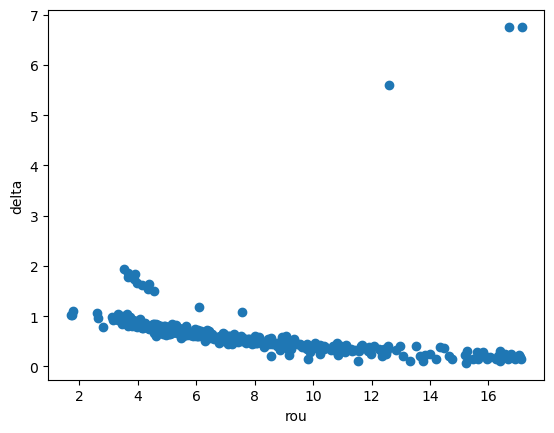

In [40]:
import matplotlib.pyplot as plt
plt.scatter(rho_Gauss[:, 1], delta[:, 1], marker='o')
plt.xlabel('rou')
plt.ylabel('delta')
plt.show()

# choose the cluster centers

In [41]:
points_descended_by_gamma = np.zeros([n_points,4])
points_descended_by_gamma[:,0:2] = rho_Gauss
points_descended_by_gamma[:,2] = delta[:,1]
points_descended_by_gamma[:,3] = rho_Gauss[:,1] * delta[:,1]
points_descended_by_gamma = my_sort(points_descended_by_gamma,3,'descending')

column of points:
* c0 is id
* c1 is rho
* c2 is delta
* c3 is rho*delta
* c4 is cluster label

## plot $\rho \cdot \delta$ ~ number

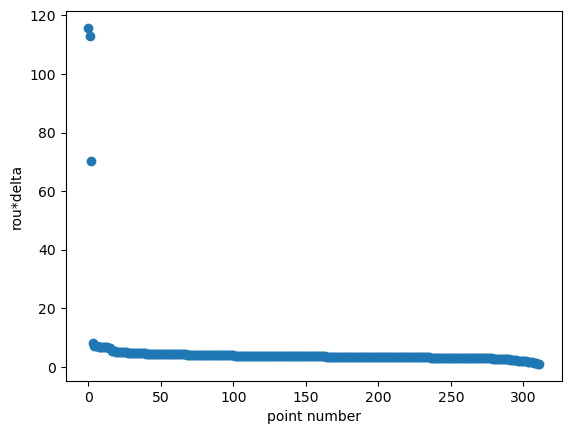

In [42]:
import matplotlib.pyplot as plt
rank = np.arange(0, n_points)
plt.scatter(rank, points_descended_by_gamma[:,3], marker='o')
plt.xlabel('point number')
plt.ylabel('rou*delta')
plt.show()

## get the cluster centers

In [43]:
step = np.quantile(points_descended_by_gamma[:,3], 0.5) # use quantile to avoid another super-parameter
for i in range(1, n_points):
    z = np.logical_and(points_descended_by_gamma[:,3] > step*i, points_descended_by_gamma[:,3] <= step*(i+1))
    if sum(z) == 0:
        break
n_cluster = sum(points_descended_by_gamma[:,3] > step*i)
id_of_cluster_center = points_descended_by_gamma[0:n_cluster,0]
id_of_cluster_center = id_of_cluster_center.astype(int)

other paussible method to choose the cluster centers
* method2: use 2 percentage as threshold
* method3: use cluster method or SVM in delta~rho or rou*delta~t
* method4: let the user draw a rectangular (the original paper use this straightforward but subjective method)

# plot cluster centers

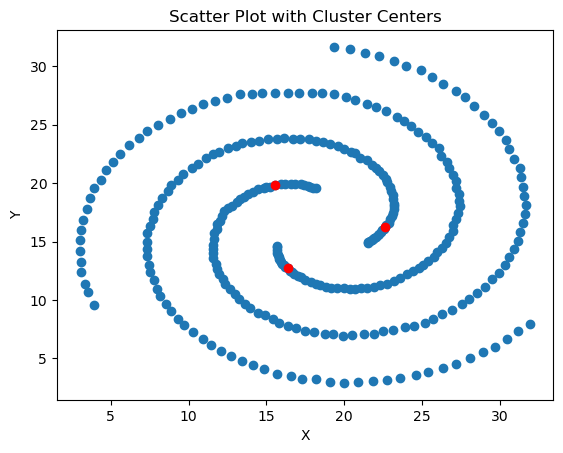

In [44]:
#
# plot the cluster center in red and others in blue
#

# Scatter plot for x and y
plt.scatter(df[:, 0], df[:, 1], marker='o')

# Scatter plot for cluster center
plt.scatter(df[id_of_cluster_center, 0], df[id_of_cluster_center, 1], c='r', marker='o')

# Labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot with Cluster Centers')

plt.show()

# allocate

In [45]:
# add a new column for cluster label
points_descended_by_gamma = np.append(points_descended_by_gamma, np.zeros([n_points,1]), axis=1)

# put the cluster center into each cluster
for i in range(n_cluster):
    points_descended_by_gamma[i,4] = i + 1

In [46]:
# descend points by id
points_descended_by_id = my_sort(points_descended_by_gamma,0,'descending')

In [47]:
# descend points by rho
points_descended_by_rho = my_sort(points_descended_by_gamma,1,'descending')

## method 1
each remaining point is assigned to the same cluster as its nearest neighbor within 5 $d_c$ of higher density

In [48]:
# # flag for dist
# is_neigh = dist <= d_c * 5 # I use 5 to make sure that I can find a neighbor with higher density. # 5 is kind of super-parameter, can be 100 too.

# def find_the_nearest_neighbor_with_higher_density(i):

#     # if this point already has label
#     if points_descended_by_id[i,4] != 0:
#         return
    
#     # get all neighbors for point i
#     flag_neighbor = is_neigh[i,:]
#     neighbor = points_descended_by_id[flag_neighbor]

#     # get dists between point i and its neighbors
#     dist_neighbor = dist[i,:][flag_neighbor]

#     # find the neighbors with higher density
#     neighbor = np.append(neighbor, dist_neighbor[:,np.newaxis], axis=1)
#     neighbor = neighbor[neighbor[:,1] > points_descended_by_id[i,1] + 10**(-4)] # 10**(-4) is used to avoid include itself
    
#     # sort by distance (from closest to farthest)
#     neighbor = neighbor[np.argsort(neighbor[:, 5])]

#     # if the highest density neighbor already has label
#     if neighbor[0,4] != 0:
#         points_descended_by_id[i,4] = neighbor[0,4]
    
#     # if the highest density neighbor has no label
#     else:
#         find_the_nearest_neighbor_with_higher_density(int(neighbor[0,0])) # recursion
#         points_descended_by_id[i,4] = points_descended_by_id[int(neighbor[0,0]),4]

# # loop to find the cluster for each point
# for i in range(N):
#     find_the_nearest_neighbor_with_higher_density(i)

## method 2
each remaining point is assigned to the same cluster as its nearest neighbor within $+\infty$ of higher density

In [49]:
for i in range(n_points):
    if points_descended_by_rho[i,4] == 0:
        idx = int(nearest_neighbor_of_higher_density[i,1])
        position = np.where(points_descended_by_rho[:,0] == idx)[0]
        points_descended_by_rho[i,4] = int(points_descended_by_rho[position,4])

## plot

In [50]:
def generate_color_map(cluster_label, max_colors=100, skip=5):

    unique_labels = np.unique(cluster_label)
    
    # Generate distinct colors
    available_colors = plt.cm.gnuplot(np.linspace(0, 1, max_colors))
    
    # Create a dynamic color map: This dictionary assigns a fixed color to each unique value in 'unique_labels'
    color_map = {}
    for i, label in enumerate(unique_labels):
        color_map[label] = available_colors[(i * skip) % max_colors]
        
    return color_map

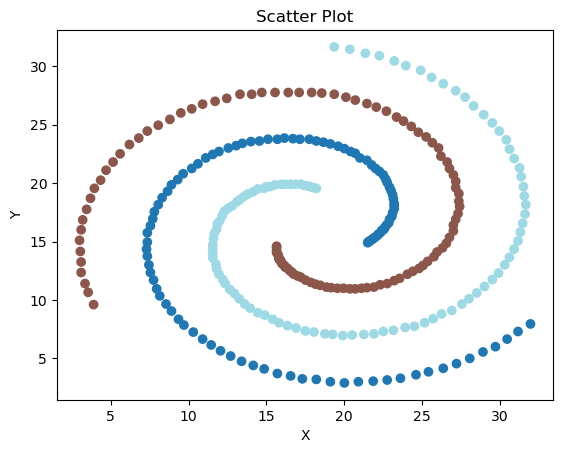

In [51]:
points_ascended_by_id = my_sort(points_descended_by_rho,0,'ascending')
cluster_label = points_ascended_by_id[:,4].astype(int)

# color_map = generate_color_map(cluster_label)
# colors = [color_map[label] for label in cluster_label]

plt.scatter(df[:, 0], df[:, 1], c = cluster_label, cmap="tab20")
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot')
plt.show()

# Add Border Region

In [52]:
cluster_label_bord = cluster_label.copy()
    
# Initialize bord_rho array
bord_rho = np.zeros(n_cluster)

# Loop to update bord_rho
for i in range(n_points - 1):
    for j in range(i + 1, n_points):
        if cluster_label[i] != cluster_label[j] and dist[i, j] <= d_c:

            # add label for border region
            cluster_label_bord[i] = 0
            cluster_label_bord[j] = 0
            
            # Update bord_rho for cluster_label[i]
            if rho_Gauss[i,1] > bord_rho[cluster_label[i] - 1]:
                bord_rho[cluster_label[i] - 1] = rho_Gauss[i,1]
            
            # Update bord_rho for cluster_label[j]
            if rho_Gauss[j,1] > bord_rho[cluster_label[j] - 1]:
                bord_rho[cluster_label[j] - 1] = rho_Gauss[j,1]

In [53]:
rho_Gauss[248,1]

4.243355450578404

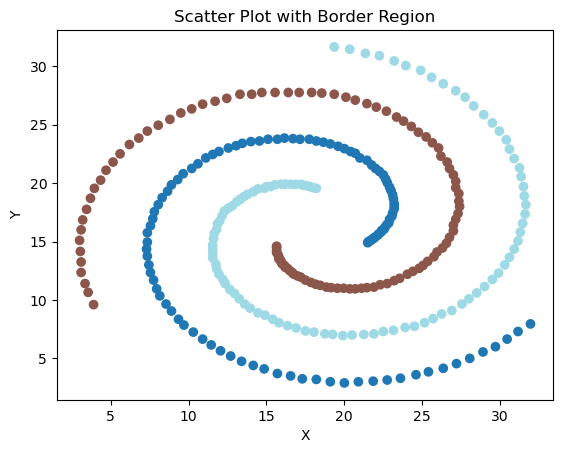

In [54]:
#
plt.scatter(df[:, 0], df[:, 1], c = cluster_label, cmap="tab20")

# plot bolder region
idx_border = np.where(cluster_label_bord == 0)[0]
plt.scatter(df[idx_border, 0], df[idx_border, 1], c='black', marker='o')

# label and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot with Border Region')

# 
plt.show()

# Add Halo

In [55]:
halo = cluster_label.copy()
for i in range(n_points):
    if rho_Gauss[i,1] < bord_rho[cluster_label[i] - 1]:
        halo[i] = 0

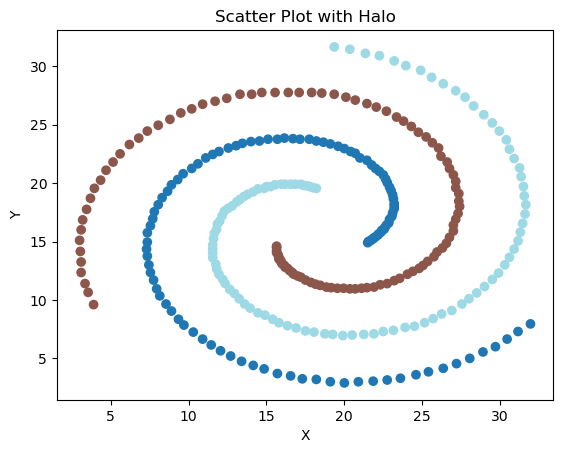

In [56]:
#
plt.scatter(df[:, 0], df[:, 1], c = cluster_label, cmap="tab20")

# plot halo
idx_halo = np.where(halo == 0)[0]
plt.scatter(df[idx_halo, 0], df[idx_halo, 1], c='black', marker='o')

# label and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot with Halo')

# 
plt.show()

# Davies-Bouldin Index 

In [57]:
from sklearn import metrics
metrics.davies_bouldin_score(df, cluster_label)

5.882022552277642

* Aggregation: 0.5036
* R15: 0.3148
* D31: 0.5519

# conclusion
* this algorithm
  * 该算法帅气优雅简洁（自不必说）、普适（可以用于球形和非球形数据集），是我们物理学家会喜欢的算法。
  * 该算法结合了K-means和DBSCAN的优点
* Further improvement
  * 光晕点
    * 原论文中给出了光晕点的定义，这个定义自然地给出了寻找方法
    * 所有的光晕点为新的一类，用一种新的颜色表示
  * 离群点
    * 原论文中把$\rho$小$\delta$大的点定义为离群点
    * 我们也可以把在$5d_c$中都没有更大密度邻居的点定义为离群点
    * 所有的离群点也可以被划分为新的一类，用一种新的颜色表示